# 第11回演習：AIモデルを支えるハードウェア

本演習では以下の内容を扱います：

1. **ハードウェア情報の確認**
2. **CPU vs GPU 速度比較実験**
3. **メモリ使用量の観察**
4. **CPU/GPU 学習時間の比較 (MNIST)**

## 0. 準備：ライブラリのインポートと環境設定

In [28]:
import subprocess
import time
import warnings

import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
import psutil
import torch
import torch.nn as nn
import cupy as cp

warnings.filterwarnings("ignore")

# 日本語フォントの設定（必要に応じて）
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "DejaVu Sans"]

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

device = torch.device("cuda")
print(f"使用デバイス: {device}")

PyTorch version: 2.9.1+cu128
NumPy version: 2.3.3
使用デバイス: cuda


## 演習1：ハードウェア情報の確認

この演習では，現在使用している計算環境のハードウェア情報を確認します．
- GPU情報
- CPU情報
- メモリ情報

※ Windowsの場合，スペック情報を確認するには以下のコマンドをコマンドプロンプトで実行してください：
> systeminfo
または
> dxdiag

In [29]:
# --- GPU情報の確認 ---
print("【GPU情報】")
print("-" * 70)

print("✓ CUDA is available")
print(f"✓ CUDA version: {torch.version.cuda}")
print(f"✓ Number of GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
    gpu_memory = torch.cuda.get_device_properties(i).total_memory
    print(f"  Total Memory: {gpu_memory / 1e9:.2f} GB")

# nvidia-smiコマンドを実行
print("\n【nvidia-smi 出力】")
try:
    result = subprocess.run(
        ["nvidia-smi"], capture_output=True, text=True, check=True
    )
    print(result.stdout)
except (subprocess.CalledProcessError, FileNotFoundError):
    print("nvidia-smi コマンドが利用できません")

【GPU情報】
----------------------------------------------------------------------
✓ CUDA is available
✓ CUDA version: 12.8
✓ Number of GPUs: 1

GPU 0: NVIDIA GeForce RTX 5070 Ti
  Total Memory: 16.61 GB

【nvidia-smi 出力】
Mon Dec 22 15:00:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     Off |   00000000:02:00.0 Off |                  N/A |
|  0%   44C    

In [30]:
# --- CPU情報の確認 ---
print("\n【CPU情報】")
print("-" * 70)

# lscpuコマンドを実行（Linux/Mac）
print("【CPU詳細情報】")
try:
    result = subprocess.run(
        ["lscpu"], capture_output=True, text=True, check=True, timeout=5
    )
    # 重要な情報のみ抽出
    for line in result.stdout.split("\n"):
        if any(
            keyword in line
            for keyword in [
                "Model name",
                "CPU(s)",
                "Thread(s)",
                "Core(s)",
                "Socket(s)",
                "CPU MHz",
            ]
        ):
            print(line)
except (subprocess.CalledProcessError, FileNotFoundError, subprocess.TimeoutExpired):
    # Windowsまたはコマンド失敗時はpythonで取得
    print(f"CPU コア数: {psutil.cpu_count(logical=False)} (物理)")
    print(f"CPU スレッド数: {psutil.cpu_count(logical=True)} (論理)")
    print(f"CPU 使用率: {psutil.cpu_percent(interval=1)}%")


【CPU情報】
----------------------------------------------------------------------
【CPU詳細情報】
CPU(s):                                  20
On-line CPU(s) list:                     0-19
Model name:                              Intel(R) Core(TM) Ultra 7 265K
Thread(s) per core:                      1
Core(s) per socket:                      20
Socket(s):                               1
CPU(s) scaling MHz:                      51%
NUMA node0 CPU(s):                       0-19


In [31]:
# --- メモリ情報の確認 ---
print("\n【メモリ情報】")
print("-" * 70)

ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / 1e9:.2f} GB")
print(f"Available RAM: {ram.available / 1e9:.2f} GB")
print(f"Used RAM: {ram.used / 1e9:.2f} GB")
print(f"RAM Usage: {ram.percent}%")

# GPU Memory
print("\nGPU Memory (Device 0):")
print(f"  Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"  Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")


【メモリ情報】
----------------------------------------------------------------------
Total RAM: 66.85 GB
Available RAM: 60.46 GB
Used RAM: 6.39 GB
RAM Usage: 9.6%

GPU Memory (Device 0):
  Allocated: 0.21 GB
  Reserved: 0.25 GB


## 演習2：CPU vs GPU 速度比較実験

この演習では，CPUとGPUで同じ行列積の計算を行い，速度を比較します．
- NumPy (CPU) と CuPy (GPU) を使用
- 行列サイズを変えて実験
- 計算時間を測定

In [32]:
# 行列サイズのリスト
sizes = [100, 500, 1000, 2000, 5000]
cpu_times = []
gpu_times = []

print("\n行列積の計算速度を測定中...")
print("-" * 70)

for n in sizes:
    print(f"\n行列サイズ: {n} × {n}")

    # --- CPU (NumPy) ---
    A_cpu = np.random.rand(n, n).astype(np.float32)
    B_cpu = np.random.rand(n, n).astype(np.float32)

    start = time.time()
    C_cpu = A_cpu @ B_cpu
    cpu_time = time.time() - start
    cpu_times.append(cpu_time)
    print(f"  CPU (NumPy):  {cpu_time:.4f} 秒")

    # --- GPU (CuPy) ---
    A_gpu = cp.random.rand(n, n).astype(cp.float32)
    B_gpu = cp.random.rand(n, n).astype(cp.float32)

    # ウォームアップ（初回は遅いことがあるため）
    _ = A_gpu @ B_gpu
    cp.cuda.Stream.null.synchronize()

    start = time.time()
    C_gpu = A_gpu @ B_gpu
    cp.cuda.Stream.null.synchronize()  # GPU計算の完了を待つ
    gpu_time = time.time() - start
    gpu_times.append(gpu_time)
    print(f"  GPU (CuPy):   {gpu_time:.4f} 秒")

    # 高速化率
    speedup = cpu_time / gpu_time
    print(f"  高速化率:     {speedup:.1f}x")

    # 結果の検証（計算結果が正しいか確認）
    diff = np.abs(C_cpu - cp.asnumpy(C_gpu)).max()
    print(f"  最大誤差:     {diff:.2e}")


行列積の計算速度を測定中...
----------------------------------------------------------------------

行列サイズ: 100 × 100
  CPU (NumPy):  0.0004 秒
  GPU (CuPy):   0.0000 秒
  高速化率:     9.9x
  最大誤差:     1.40e+01

行列サイズ: 500 × 500
  CPU (NumPy):  0.0005 秒
  GPU (CuPy):   0.0000 秒
  高速化率:     12.5x
  最大誤差:     3.59e+01

行列サイズ: 1000 × 1000
  CPU (NumPy):  0.0016 秒
  GPU (CuPy):   0.0001 秒
  高速化率:     13.1x
  最大誤差:     4.83e+01

行列サイズ: 2000 × 2000
  CPU (NumPy):  0.0097 秒
  GPU (CuPy):   0.0006 秒
  高速化率:     15.1x
  最大誤差:     7.72e+01

行列サイズ: 5000 × 5000
  CPU (NumPy):  0.1503 秒
  GPU (CuPy):   0.0086 秒
  高速化率:     17.4x
  最大誤差:     1.25e+02


### 結果の可視化と考察

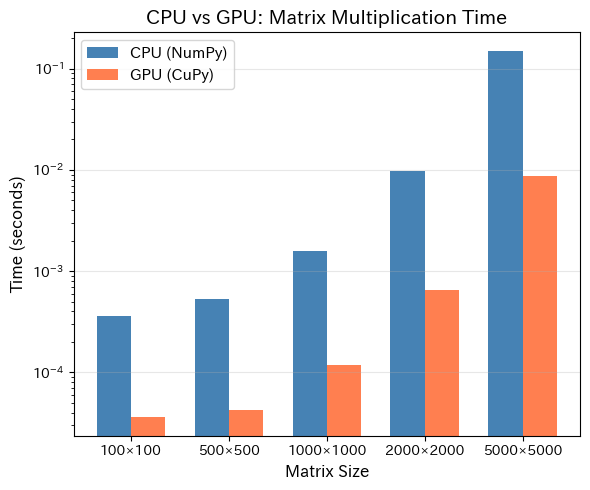


【実験結果サマリー】
----------------------------------------------------------------------
最小高速化率: 9.9x (行列サイズ: 100×100)
最大高速化率: 17.4x (行列サイズ: 5000×5000)


In [39]:
# --- 結果の可視化 ---
fig, ax = plt.subplots(figsize=(6, 5))

# 計算時間の比較
x_pos = np.arange(len(sizes))
width = 0.35

ax.bar(x_pos - width / 2, cpu_times, width, label="CPU (NumPy)", color="steelblue")
ax.bar(x_pos + width / 2, gpu_times, width, label="GPU (CuPy)", color="coral")

ax.set_xlabel("Matrix Size", fontsize=12)
ax.set_ylabel("Time (seconds)", fontsize=12)
ax.set_title(
    "CPU vs GPU: Matrix Multiplication Time", fontsize=14, fontweight="bold"
)
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{s}×{s}" for s in sizes])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis="y")
ax.set_yscale("log")  # 対数スケール

plt.tight_layout()
plt.show()

# --- 結果のサマリー ---
speedups = [c / g for c, g in zip(cpu_times, gpu_times)]

print("\n【実験結果サマリー】")
print("-" * 70)
print(
    f"最小高速化率: {min(speedups):.1f}x (行列サイズ: {sizes[speedups.index(min(speedups))]}×{sizes[speedups.index(min(speedups))]})"
)
print(
    f"最大高速化率: {max(speedups):.1f}x (行列サイズ: {sizes[speedups.index(max(speedups))]}×{sizes[speedups.index(max(speedups))]})"
)

#### 考察
行列サイズが小さいときはGPUのオーバーヘッド（データ転送時間等）が相対的に大きくなるため，高速化率が低くなります．
行列サイズが大きくなるほど，GPUの並列計算能力が発揮され，CPUに対して圧倒的に高速になります．

## 演習3：メモリ使用量の観察

この演習では，ニューラルネットワークのパラメータ数とメモリ使用量の関係を観察します．
- モデルサイズとメモリの関係を推定
- 実際のPre-trainedモデル（ResNet等）をロードしてメモリを確認
- 大規模モデル（GPT-3等）のメモリ要件を理解

In [34]:
# --- シンプルな全結合ニューラルネットワーク ---
class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def count_parameters(model):
    """モデルのパラメータ数をカウント"""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


def estimate_memory(num_params, dtype="float32"):
    """パラメータ数からメモリ使用量を推定"""
    bytes_per_param = {"float32": 4, "float16": 2, "int8": 1}
    bytes_size = bytes_per_param.get(dtype, 4)
    memory_bytes = num_params * bytes_size
    return memory_bytes / 1e6  # MB単位で返す


# --- モデルサイズを変えて実験 ---
# configsは「大」のみに変更
configs = [
    ("大", 10000, 4096, 1000),
]

print("\n【モデルサイズとメモリ使用量】")
print("-" * 70)

results = []

for name, input_size, hidden_size, output_size in configs:
    model = SimpleModel(input_size, hidden_size, output_size)
    total, trainable = count_parameters(model)

    # メモリ使用量を推定
    memory_params = estimate_memory(total, "float32")
    memory_with_grads = memory_params * 2  # 勾配も保存するため

    results.append(
        {
            "name": name,
            "config": f"{input_size}→{hidden_size}→{output_size}",
            "params": total,
            "memory_params": memory_params,
            "memory_grads": memory_with_grads,
        }
    )

    print(f"\nモデルサイズ: {name}")
    print(f"  構成:             {input_size} → {hidden_size} → {output_size}")
    print(f"  パラメータ数:     {total:,}")
    print(f"  メモリ (重みのみ): {memory_params:.2f} MB")
    print(f"  メモリ (勾配込み): {memory_with_grads:.2f} MB")


【モデルサイズとメモリ使用量】
----------------------------------------------------------------------



モデルサイズ: 大
  構成:             10000 → 4096 → 1000
  パラメータ数:     61,842,408
  メモリ (重みのみ): 247.37 MB
  メモリ (勾配込み): 494.74 MB


In [35]:
# --- 実際のモデルロード実験 ---
print("\n【実際のモデルロード実験】")
print("-" * 70)

import torchvision.models as models

# メモリをクリア
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

print("ResNet50をロード中...")
try:
    resnet50 = models.resnet50(pretrained=False).to(device)

    # ダミー入力で一度推論してメモリを確保させる
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    _ = resnet50(dummy_input)

    allocated = torch.cuda.memory_allocated() / 1e6
    reserved = torch.cuda.memory_reserved() / 1e6
    peak = torch.cuda.max_memory_allocated() / 1e6

    print(f"\nResNet50:")
    print(f"  Allocated: {allocated:.2f} MB")
    print(f"  Reserved:  {reserved:.2f} MB")
    print(f"  Peak:      {peak:.2f} MB")

    del resnet50, dummy_input
    torch.cuda.empty_cache()

except Exception as e:
    print(f"エラー: モデルのロードに失敗しました - {e}")


【実際のモデルロード実験】
----------------------------------------------------------------------
ResNet50をロード中...

ResNet50:
  Allocated: 209.15 MB
  Reserved:  234.88 MB
  Peak:      221.79 MB



【有名な大規模モデルのメモリ要件】
----------------------------------------------------------------------
モデル名                 パラメータ数          メモリ (FP32)      メモリ (FP16)     
----------------------------------------------------------------------
ResNet-50                   0.0B          0.1 GB          0.1 GB
BERT-Base                   0.1B          0.4 GB          0.2 GB
GPT-2                       1.5B          6.0 GB          3.0 GB
GPT-3                     175.0B        700.0 GB        350.0 GB
GPT-4 (推定)               1700.0B       6800.0 GB       3400.0 GB

💡 考察:
   - GPT-3クラスのモデルは，重みだけで700GB（FP32）必要
   - 学習時は勾配やオプティマイザの状態も保存するため，さらに2-4倍必要
   - そのため，複数のGPUに分散して配置する必要がある
   - FP16やInt8量子化により，メモリ使用量を削減可能


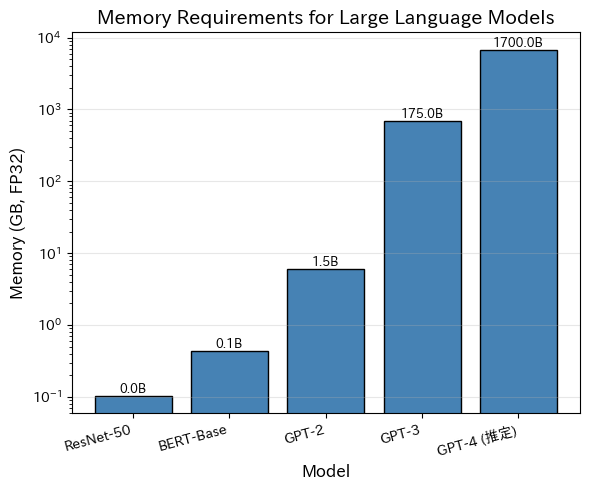

In [40]:
# --- 大規模モデルのメモリ推定 ---
print("\n【有名な大規模モデルのメモリ要件】")
print("-" * 70)

large_models = {
    "ResNet-50": 25.6e6,
    "BERT-Base": 110e6,
    "GPT-2": 1.5e9,
    "GPT-3": 175e9,
    "GPT-4 (推定)": 1.7e12,
}

print(
    f"{'モデル名':<20} {'パラメータ数':<15} {'メモリ (FP32)':<15} {'メモリ (FP16)':<15}"
)
print("-" * 70)

for name, params in large_models.items():
    memory_fp32 = params * 4 / 1e9  # GB
    memory_fp16 = params * 2 / 1e9  # GB
    print(
        f"{name:<20} {params / 1e9:>10.1f}B {memory_fp32:>12.1f} GB {memory_fp16:>12.1f} GB"
    )

print("\n💡 考察:")
print("   - GPT-3クラスのモデルは，重みだけで700GB（FP32）必要")
print("   - 学習時は勾配やオプティマイザの状態も保存するため，さらに2-4倍必要")
print("   - そのため，複数のGPUに分散して配置する必要がある")
print("   - FP16やInt8量子化により，メモリ使用量を削減可能")

# --- 可視化 ---
fig, ax = plt.subplots(figsize=(6, 5))

model_names = list(large_models.keys())
params_billions = [large_models[name] / 1e9 for name in model_names]
memory_fp32_gb = [p * 4 / 1e9 for p in [large_models[name] for name in model_names]]

x_pos = np.arange(len(model_names))
bars = ax.bar(x_pos, memory_fp32_gb, color="steelblue", edgecolor="black")

ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Memory (GB, FP32)", fontsize=12)
ax.set_title(
    "Memory Requirements for Large Language Models", fontsize=14, fontweight="bold"
)
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=15, ha="right")
ax.set_yscale("log")
ax.grid(True, alpha=0.3, axis="y")

# 各棒にパラメータ数を表示
for i, (bar, params) in enumerate(zip(bars, params_billions)):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{params:.1f}B",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

## 演習4：CPU/GPU 学習時間の比較 (MNIST)

この演習では，手書き数字データセット (MNIST) を用いて，実際のディープラーニング学習におけるCPUとGPUの速度差を比較します．
- 使用モデル: シンプルな多層パーセプトロン (MLP)
- データセット: MNIST (28x28画像，10クラス)

In [37]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- データセットの準備 ---
print("MNISTデータセットを準備中...")

# 変換定義 (Tensor変換 + 正規化)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# データセットのダウンロードとロード
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
train_dataset = torch.utils.data.Subset(train_dataset, torch.randperm(len(train_dataset))[:10000])

# --- 学習ループ関数 ---
def train_model(device_name, dataset, batch_size=64, epochs=5):
    """指定されたデバイスでMNISTの学習を実行"""
    device = torch.device(device_name)

    # DataLoaderの作成
    # num_workers=2だと環境によってはハングするため0にする
    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=(device_name == "cuda")
    )

    # モデル定義 (MNIST用: 28x28=784入力，10出力)
    # Hiddenサイズは少し大きめに設定して計算負荷をかける
    model = SimpleModel(input_size=784, hidden_size=1024, output_size=10).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # ウォームアップ (モデルとデータをGPUに載せるオーバーヘッドを初回で消化)
    if device_name == "cuda":
        dummy_in = torch.randn(1, 784).to(device)
        model(dummy_in)
        torch.cuda.synchronize()

    print(f"\n[{device_name.upper()}] 学習開始 (Epochs: {epochs})...")
    start_time = time.time()

    model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            # データをデバイスへ転送
            data, target = data.to(device), target.to(device)

            # 画像をフラットにする (N, 1, 28, 28) -> (N, 784)
            data = data.view(-1, 28*28)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    if device_name == "cuda":
        torch.cuda.synchronize()

    elapsed_time = time.time() - start_time
    print(f"[{device_name.upper()}] 完了: {elapsed_time:.4f} 秒")

    return elapsed_time

# --- 実験設定 ---
BATCH_SIZE = 128
EPOCHS = 5

print(f"設定: Batch Size={BATCH_SIZE}, Epochs={EPOCHS}")
print("※ CPUでの学習は時間がかかる場合があります...")

# CPUでの学習
cpu_time = train_model("cpu", train_dataset, BATCH_SIZE, EPOCHS)

# GPUでの学習
gpu_time = train_model("cuda", train_dataset, BATCH_SIZE, EPOCHS)

speedup = cpu_time / gpu_time
print(f"\n高速化率: {speedup:.2f}x")

MNISTデータセットを準備中...
設定: Batch Size=128, Epochs=5
※ CPUでの学習は時間がかかる場合があります...

[CPU] 学習開始 (Epochs: 5)...


[CPU] 完了: 2.4618 秒

[CUDA] 学習開始 (Epochs: 5)...
[CUDA] 完了: 1.8204 秒

高速化率: 1.35x


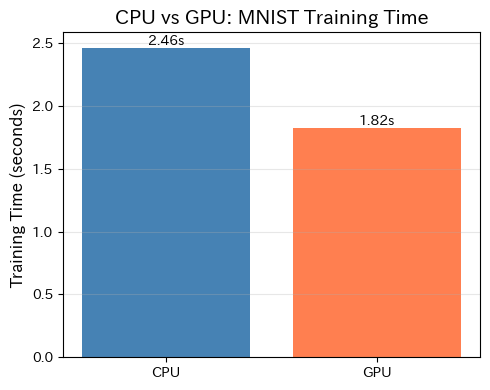

In [38]:
# --- 可視化 ---
fig, ax = plt.subplots(figsize=(5, 4))

devices = ['CPU', 'GPU']
times = [cpu_time, gpu_time]
colors = ['steelblue', 'coral']

bars = ax.bar(devices, times, color=colors)

ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('CPU vs GPU: MNIST Training Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 時間を表示
for bar, t in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{t:.2f}s',
            ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()

#### 考察
- 実際のデータセットを用いた学習では，計算だけでなくデータローディング（ディスク読込→CPU処理→GPU転送）も重要になります
- それでもGPUの演算速度は圧倒的であり，学習時間を大幅に短縮できます

## 演習のまとめ

本演習で学んだこと：

1. **ハードウェア情報の確認**
   - GPU，CPU，メモリの仕様を確認
   - 自分が使っている計算環境を理解する重要性

2. **CPU vs GPU 速度比較**
   - GPUは大規模な行列演算で圧倒的に高速
   - 小規模データではCPUの方が速い場合もある
   - データ転送のオーバーヘッドを考慮する必要がある

3. **メモリ使用量の観察**
   - パラメータ数とメモリ使用量は比例する
   - 大規模モデルには膨大なメモリが必要
   - FP16やInt8量子化でメモリを削減可能
   - 学習時は推論時の2-4倍のメモリが必要

4. **CPU/GPU 学習時間の比較**
   - 実際の学習ループにおいてもGPUは有効
   - 行列演算主体のDeep LearningはGPUなしでは実用的ではない
